# 캐글 신용카드 사기 검출

해당 데이터 세트의 레이블인 Class 속성은 매우 불균형한 분포를 가지고 있다. Class는 0과 1로 분류되며, 0은 사기가 아닌 정상적인 신용카드 트랜잭션 데이터이고 1은 신용카드 트랜잭션 데이터를 의미한다. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

card_df = pd.read_csv('./CreditCardFraud/creditcard.csv')
card_df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [2]:
card_df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [3]:
zero_cnt = card_df[card_df['Class'] == 1].Class.count()
total_cnt = card_df.Class.count()
print('사기 트랜잭션 비율 : {0:.2f}'.format(zero_cnt / total_cnt * 100))

사기 트랜잭션 비율 : 0.17


전체 데이터의 약 0.17%만이 사기 트랜잭션이다. 일반적으로 사기 검출(Fraud Detection)이나 이상 검출(Anomaly Detection)과 같은 데이터 세트는 이처럼 레이블 값이 극도로 불균형한 분포를 가지기 쉽다. 

# 언더 샘플링과 오버 샘플링의 이해

이상 레이블을 가지는 데이터 건수는 매우 적기 때문에 제대로 다양한 유형을 학습하지 못하는 반면, 정상 레이블을 가지는 데이터 건수는 매우 많기 때문에 일방적으로 정상 레이블로 치우친 학습을 수행해 제대로 된 이상 데이터 검출이 어려워지기 쉽다. 지도 학습에서 극도로 불균형한 레이블 값 분포로 인한 문제점을 해결하기 위해 적절한 학습 데이터를 확보하는 방안이 필요한데, 대표적으로 오버 샘플링(Oversampling)과 언더 샘플링(Undersampling) 방법이 있다. 오버 샘플링이 예측 성능상 더 유리한 경우가 많아 주로 사용된다.

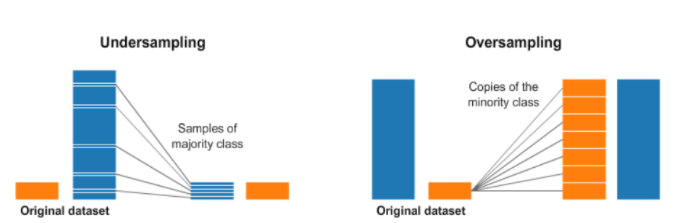

### 언더 샘플링
* 많은 데이터 세트를 적은 데이터 세트 수준으로 감소시키는 방식
* 너무 많은 정상 레이블 데이터를 감소시키면 오히려 제대로 된 학습을 수행할 수 없다는 단점이 있어 잘 적용되지 않는다.

### 오버 샘플링
* 이상 데이터와 같이 적은 데이터 세트를 증식하여 학습을 위한 충분한 데이터를 확보하는 방식
* 동일한 데이터를 단순히 증식시키는 방법은 과적합되기 때문에 의미가 없다. 원본 데이터의 피처 값들을 아주 약간만 변경하여 증식.
* 대표적인 방법 = SMOTE(Synthetic Minority Over-sampling Technique)
* SMOTE는 적은 데이터 세트에 있는 개별 데이터들의 K 최근접 아웃(K Nearst Neighbor)을 찾아서 이 데이터와 K개 이웃들의 차이를 일정 값으로 만들어 기존 데이터와 약간 차이가 나는 새로운 데이터들을 생성하는 방식

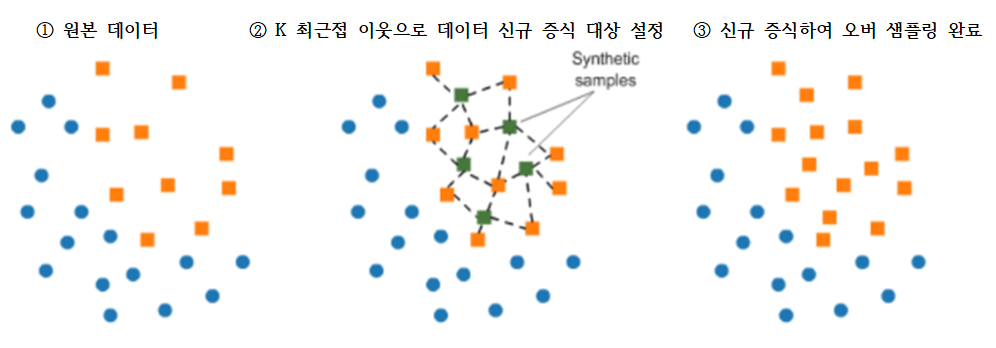

# 데이터 일차 가공 및 모델 학습/예측/평가

In [4]:
card_df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


V로 시작하는 피처들의 의미는 알 수 없다. Time 피처의 경우 데이터 생성 관련한 작업용 속성으로서 큰 의미가 없기에 제거한다. Amount 피처는 신용카드 트랜잭션 금액을 의미하고, Class는 레이블이다. 

In [5]:
card_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

284,807 개의 레코드에서 결측치(Missing Value)는 없으며, Class 레이블만 int형이고 나머지 피처들은 모두 float형이다.

In [6]:
from sklearn.model_selection import train_test_split

# 인자로 입력받은 DataFrame을 복사한 뒤 Time 칼럼은 삭제, 복사된 DataFrame 반환
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    df_copy.drop('Time', axis=1, inplace=True)
    return df_copy

get_prepocessed_df()를 호출한 뒤 학습 피처/레이블 데이터 세트, 테스트 피처/레이블 데이터 세트를 반환. get_train_test_dataset()은 내부에서 train_test_split() 함수를 호출하며, 테스트 데이터 세트를 전체의 30%인 Stratified 방식으로 추출해 학습 데이터 세트와 테스트 데이터 세트의 레이블 값 분포도를 서로 동일하게 만든다.

In [7]:
# 사전 데이터 가공 후 학습과 테스트 데이터 세트를 반환하는 함수.
def get_train_test_dataset(df=None):
    # 인자로 입력된 DataFrame의 사전 데이터 가공이 완료된 복사 DataFrame 반환
    df_copy = get_preprocessed_df(df)
    # DataFrame의 맨 마지막 컬럼이 레이블, 나머지는 피처들
    X_features = df_copy.iloc[:, :-1]
    y_target = df_copy.iloc[:, -1]
    # train_test_split( )으로 학습과 테스트 데이터 분할. stratify=y_target으로 Stratified 기반 분할
    X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0, stratify=y_target)
    # 학습과 테스트 데이터 세트 반환
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

In [8]:
# 생성한 학습과 테스트 데이터 세트의 레이블 값 비율 확인
print('학습 데이터 레이블 값 비율')
print(y_train.value_counts() / y_train.shape[0] * 100)
print('테스트 데이터 레이블 값 비율')
print(y_test.value_counts() / y_test.shape[0] * 100)

학습 데이터 레이블 값 비율
0    99.827451
1     0.172549
Name: Class, dtype: float64
테스트 데이터 레이블 값 비율
0    99.826785
1     0.173215
Name: Class, dtype: float64


큰 차이 없이 잘 분할되었다. 로지스틱 회귀와 LightGBM 기반 모델이 데이터 가공을 수행하면서 예측 성능이 어떻게 변하는지 확인.

In [9]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [10]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
lr_pred_proba = lr_clf.predict_proba(X_test)[:, 1]

get_clf_eval(y_test, lr_pred, lr_pred_proba)

오차 행렬
[[85280    15]
 [   55    93]]
정확도: 0.9992, 정밀도: 0.8611, 재현율: 0.6284, F1: 0.7266, AUC:0.9568


LogisticRegression 결과 재현율이 0.6284로 매우 낮다.

In [11]:
# 인자로 사이킷런의 Estimator객체와, 학습/테스트 데이터 세트를 입력 받아서 학습/예측/평가 수행.
def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None):
    model.fit(ftr_train, tgt_train)
    pred = model.predict(ftr_test)
    pred_proba = model.predict_proba(ftr_test)[:, 1]
    get_clf_eval(tgt_test, pred, pred_proba)

본 데이터 세트는 극도로 불균형한 레이블 값 분포도를 가지고 있어 LGBMClassifier 객체 생성 시 boost_from_average=False로 파라미터를 생성해야 한다.

In [12]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

오차 행렬
[[85289     6]
 [   36   112]]
정확도: 0.9995, 정밀도: 0.9492, 재현율: 0.7568, F1: 0.8421, AUC:0.9797


재현율 0.7568으로 위 로지스틱 회귀보다 높은 수치를 나타낸다.

# 데이터 분포도 변환 후 모델 학습/예측/평가

왜곡된 분포도를 가지는 데이터를 재가공한 뒤에 모델을 다시 테스트해보자.

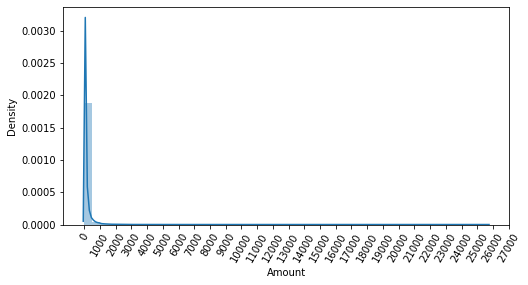

In [13]:
import seaborn as sns

plt.figure(figsize=(8, 4))
plt.xticks(range(0, 30000, 1000), rotation=60)
sns.distplot(card_df['Amount'])

card_df의 Amount(신용 카드 사용 금액) 피처의 분포도를 확인해보니 1000불 이하인 데이터가 대부분이다. Amount를 표준 정규 분포 형태로 변한한 뒤에 로지스틱 회귀의 예측 성능을 측정해보자.

In [14]:
from sklearn.preprocessing import StandardScaler
# 사이킷런의 StandardScaler를 이용하여 정규분포 형태로 Amount 피처값 변환하는 로직으로 수정. 
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    scaler = StandardScaler()
    amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1, 1))
    # 변환된 Amount를 Amount_Scaled로 피처명 변경후 DataFrame맨 앞 컬럼으로 입력
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    # 기존 Time, Amount 피처 삭제
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    return df_copy

In [15]:
# Amount를 정규분포 형태로 변환 후 로지스틱 회귀 및 LightGBM 수행. 
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('### LightGBM 예측 성능 ###')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85281    14]
 [   58    90]]
정확도: 0.9992, 정밀도: 0.8654, 재현율: 0.6081, F1: 0.7143, AUC:0.9702
### LightGBM 예측 성능 ###
오차 행렬
[[85289     6]
 [   36   112]]
정확도: 0.9995, 정밀도: 0.9492, 재현율: 0.7568, F1: 0.8421, AUC:0.9773


정규 분포 형태로 Amount 피처값을 변환한 후 테스트 데이터 세트에 적용한 로지스틱 회귀 및 LightGBM 두 모델 모두 변환 이전과 비교해 성능이 개선되지 않았다.

이번에는 StandardScaler가 아니라 로그 변환을 수행해보자.

로그 변환은 데이터 분포도가 심하게 왜곡되어 있을 경우 적용하는 중요 기법 중에 하나이다. 원래 값을 log 값으로 변환해 원래 큰 값을 상대적으로 작은 값으로 변호나하기 때문에 데이터 분포도의 왜국을 상당 수준으로 개선해준다.

로그 변환은 넘파이의 log1p() 함수를 이용해 간단히 변환이 가능하다.

In [16]:
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    # 넘파이의 log1p()
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)
    return df_copy

In [17]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('### LightGBM 예측 성능 ###')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85283    12]
 [   59    89]]
정확도: 0.9992, 정밀도: 0.8812, 재현율: 0.6014, F1: 0.7149, AUC:0.9727
### LightGBM 예측 성능 ###
오차 행렬
[[85290     5]
 [   35   113]]
정확도: 0.9995, 정밀도: 0.9576, 재현율: 0.7635, F1: 0.8496, AUC:0.9786


# 이상치 데이터 제거 후 모델 학습/예측/평가

이상치 데이터(Outlier)는 전체 데이터의 패턴에서 벗어난 이상 값을 가진 데이터이며, 아웃라이어라고 불린다.

이상치로 인해 머신러닝 모델의 성능에 영향을 받는 경우가 발생하기 쉽다. 이 이상치 데이터를 제거한 뒤에 다시 모델을 평가해보자.

### 이상치 데이터 찾아내기 - IQR(Inter Quantile Range) 방식

IQR은 사분위(Quantile) 값의 편차를 이용하는 기법으로 흔히 박스 플롯(Box Plot) 방식으로 시각화할 수 있다.

사분위는 전체 데이터를 값이 높은 순으로 정렬하고 이를 1/4(25%)씩으로 구간을 분할하는 것을 지칭. Q1, Q2, Q3, Q4로 나누어 이들 중 25% 구간인 Q1 ~ 75% 구간은 Q3의 범위를 IQR이라고 한다.

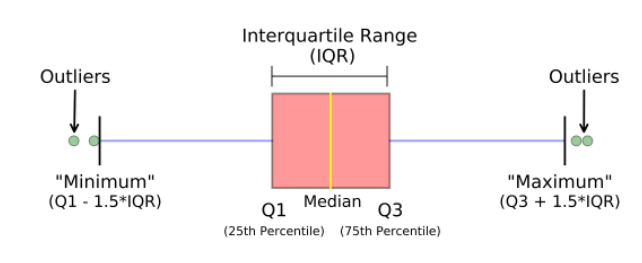

IQR을 이용해 이상치 데이터를 검출하는 방식은 보통 IQR에 1.5를 곱해서 생성된 범위를 이용해 최댓값과 최솟값을 결정한 뒤 최댓값을 초과하거나 최솟값에 미달하는 데이터를 이상치로 간주하는 것이다.

3/4 분위수(Q3)에 IQR * 1.5를 더해서 일반적인 데이터가 가질 수 있는 최댓값으로 가정하고, 1/4 분위수(Q1)에 IQR * 1.5를 빼서 일반적인 데이터가 가질 수 있는 최솟값으로 가정. (경우에 따라 1.5가 아닌 다른 값을 적용할 수 있음)

이렇게 결정된 최댓값 보다 큰, 최솟값보다 작은 값을 이상치 데이터로 간주.

이제 이상치 데이터를 IQR을 이용하여 제거해보자. 먼저 어떤 피처의 이상치 데이터를 검출할 것인지 선택이 필요하다. 매우 많은 피처가 있을 경우 이들 중 결정값(레이블)과 가장 상관성이 높은 피처들을 위주로 이상치를 검출하는 것이 좋다. 결정값과 상관성이 높지 않은 피처들의 경우 이상치는 제거해도 크게 성능 향상에 기여되지 않는다.

DataFrame의 corr()을 이용해 각 피처별로 상관도를 구한 뒤 Seaborn의 heatmap을 통해 시각화.

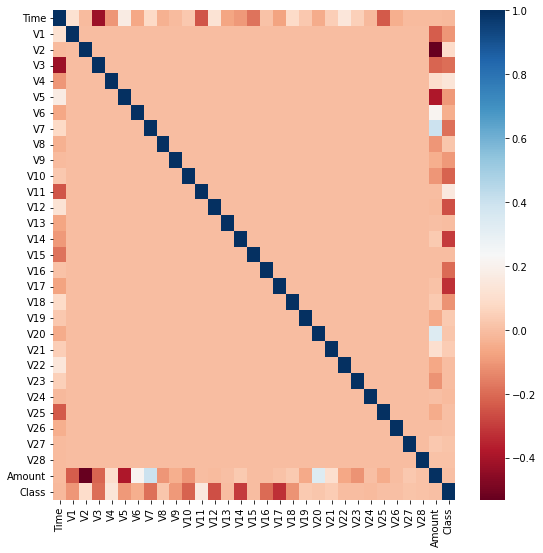

In [18]:
import seaborn as sns

plt.figure(figsize=(9, 9))
corr = card_df.corr()
sns.heatmap(corr, cmap='RdBu')

상관관께 히트맵에서 cmap을 'RdBu'로 설정해 양의 상관관계가 높을수록 색깔이 진한 파란색에 가까우며, 음의 상관관계가 높을수록 색깔이 진한 빨간색에 가깝게 표현된다.

Class 피처와 음의 상관관계가 가장 높은 피처는 V14와 V17이다. 이 중 V14에 대해서만 이상치를 찾아 제거하자. IQR을 이용해 이상치를 검출하는 함수를 생성한 뒤, 이를 이용해 검출된 이상치를 삭제.

In [19]:
def get_outlier(df=None, column=None, weight=1.5):
    # fraud에 해당하는 column 데이터만 추출, 1/4 분위와 3/4 분위 지점을 np.percentile로 구함
    fraud = df[df['Class'] == 1][column]
    quantile_25 = np.percentile(fraud.values, 25)
    quantile_75 = np.percentile(fraud.values, 75)
    # IQR을 구하고, IQR에 1.5를 곱해 최댓값과 최솟값 지점 구함
    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight
    # 최댓값보다 크거나, 최솟값보다 작은 값을 이상치 데이터로 설정하고 DataFrame index 반환
    outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index
    return  outlier_index

In [20]:
# get_outlier() 함수를 이용하여 V14 칼럼에서 이상치 데이터를 찾아보자
outlier_index = get_outlier(df=card_df, column='V14', weight=1.5)
print('이상치 데이터 인덱스 :', outlier_index)

이상치 데이터 인덱스 : Int64Index([8296, 8615, 9035, 9252], dtype='int64')


총 4개의 데이터인 8296, 8615, 9035, 9252번 Index가 이상치로 추출되었다. get_outlier()를 이용하여 이상치를 추출하고 이를 삭제하는 로직을 get_processed_df() 함수에 추가해 데이터를 가공한 뒤 이 데이터 세트를 이용하여 로지스틱 회귀와 LightGBM 모델을 다시 적용

In [21]:
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)
    # 이상치 데이터 삭제하는 로직 추가
    outlier_index = get_outlier(df=df_copy, column='V14', weight=1.5)
    df_copy.drop(outlier_index, axis=0, inplace=True)
    return df_copy

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)
print('### 로지스틱 회귀 예측 성능 ###')
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('### LightGBM 예측 성능 ###')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85281    14]
 [   48    98]]
정확도: 0.9993, 정밀도: 0.8750, 재현율: 0.6712, F1: 0.7597, AUC:0.9743
### LightGBM 예측 성능 ###
오차 행렬
[[85291     4]
 [   25   121]]
정확도: 0.9997, 정밀도: 0.9680, 재현율: 0.8288, F1: 0.8930, AUC:0.9831


로지스틱 회귀의 경우 재현율 0.6014 -> 0.6712

LightGBM의 경우 재현율 0.7635 -> 0.8288

# SMOTE 오버 샘플링 적용 후 모델 학습/예측/평가

이번에는 SMOTE 기법으로 오버 샘플링을 적용한 뒤 로지스틱 회귀와 LightGBM 모델의 예측 성능을 평가해보자.

SMOTE를 적용할 때는 반드시 학습 데이터 세트만 오버 샘플링 해야한다. 

In [22]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (199362, 29) (199362,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (398040, 29) (398040,)
SMOTE 적용 후 레이블 값 분포: 
 1    199020
0    199020
Name: Class, dtype: int64


SMOTE 적용 전 학습 데이터 세트는 199,362건이었는데 적용 후 2배에 가까운 398,040건으로 데이터 증식. 적용 후 레이블 값 0과 1의 분포가 동일하게 199,020건으로 생성되었다.

In [23]:
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, ftr_train=X_train_over, ftr_test=X_test, tgt_train=y_train_over, tgt_test=y_test)

오차 행렬
[[82937  2358]
 [   11   135]]
정확도: 0.9723, 정밀도: 0.0542, 재현율: 0.9247, F1: 0.1023, AUC:0.9737


재현율이 92.47로 크게 증가했지만, 정밀도가 5.4%로 급격하게 저하되었다.

이는 로지스틱 회귀 모델이 오버 샘플링으로 인해 실제 원본 데이터의 유형보다 너무나 많은 Class=1 데이터를 학습하면서 실제 테스트 데이터 세트에서 예측을 지나치게 Class=1로 적용해 정밀도가 급격하게 떨어진 것이다.

분류 결정 임계값에 따른 정밀도와 재현율 곡선을 통해 SMOTE로 학습된 로지스틱 회귀 모델에 어떠한 문제가 발생하고 있는지 시각적으로 확인해보자.

In [24]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics import precision_recall_curve
%matplotlib inline

def precision_recall_curve_plot(y_test , pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출. 
    precisions, recalls, thresholds = precision_recall_curve( y_test, pred_proba_c1)
    
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')
    
    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()

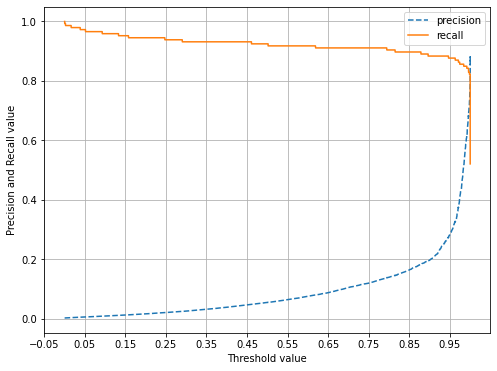

In [25]:
precision_recall_curve_plot( y_test, lr_clf.predict_proba(X_test)[:, 1] )

임계값이 0.99 이하에서는 재현율이 좋고 정밀도가 극단적으로 낮다가 0.99 이상에서는 반대로 재현율이 대폭 떨어지고 정밀도가 높아진다.

분류 결정 임꼐값을 조정하더라도 임계값의 민감도가 너무 심해 올바른 재현율/정밀도 성능을 얻을 수 없어 로지스틱 회귀 모델의 경우 SMOTE 적용 후 올바른 예측 모델이 생성되지 못한다.

이번에는 LightGBM 모델을 SMOTE로 오버 샘플링된 데이터 세트로 학습/예측/평가를 수행.

In [26]:
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train_over, ftr_test=X_test, tgt_train=y_train_over, tgt_test=y_test)

오차 행렬
[[85286     9]
 [   22   124]]
정확도: 0.9996, 정밀도: 0.9323, 재현율: 0.8493, F1: 0.8889, AUC:0.9789


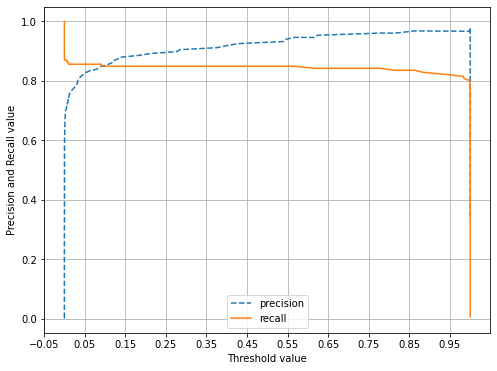

In [27]:
precision_recall_curve_plot(y_test, lgbm_clf.predict_proba(X_test)[:, 1]) 

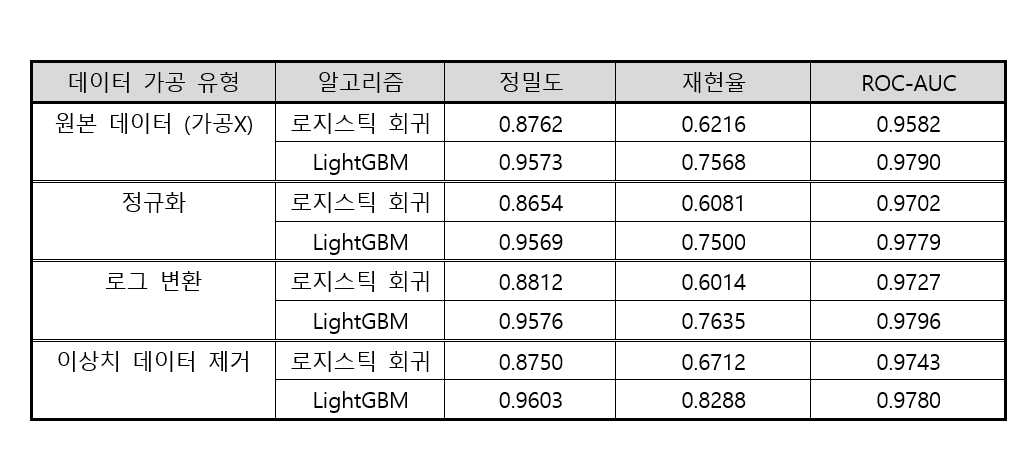